In [31]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from google.colab import drive
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
import PIL
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -qq '/content/drive/MyDrive/datasets/archive_6.zip'

In [4]:
! mkdir '/content/datasets'

In [5]:
! mv /content/Mask/Mask/* /content/datasets/

In [8]:
! mv /content/NoMask/NoMask/* /content/datasets/

In [9]:
class ImageData(Dataset):
  def __init__(self, img_path, img_labels, trans=None):
    self.img_path = img_path
    self.img_labels = torch.Tensor(img_labels)
    if trans is None:
      self.transforms = transforms.ToTensor()
    else:
      self.transforms = trans

  def __getitem__(self, index):
    curr_path = self.img_path[index]
    curr_img = PIL.Image.open(curr_path)
    curr_img = self.transforms(curr_img)

    return curr_img, self.img_labels[index]

  def __len__(self):
    return len(self.img_path)

In [10]:
img_lists = glob.glob(os.path.join('/content/datasets/', '*'))

In [11]:
labels = [0 if img_path.split('/')[3][0] == 'M' else 1 for img_path in img_lists]

In [21]:
transformations = transforms.Compose([transforms.Resize((300, 300)),  # resize to input shape of our CNN
                                      transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                      transforms.RandomRotation(40),
                                      transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()  # convert PIL to Tensor
                                      ])

In [22]:
mask_data = ImageData(img_lists, labels, trans=transformations)

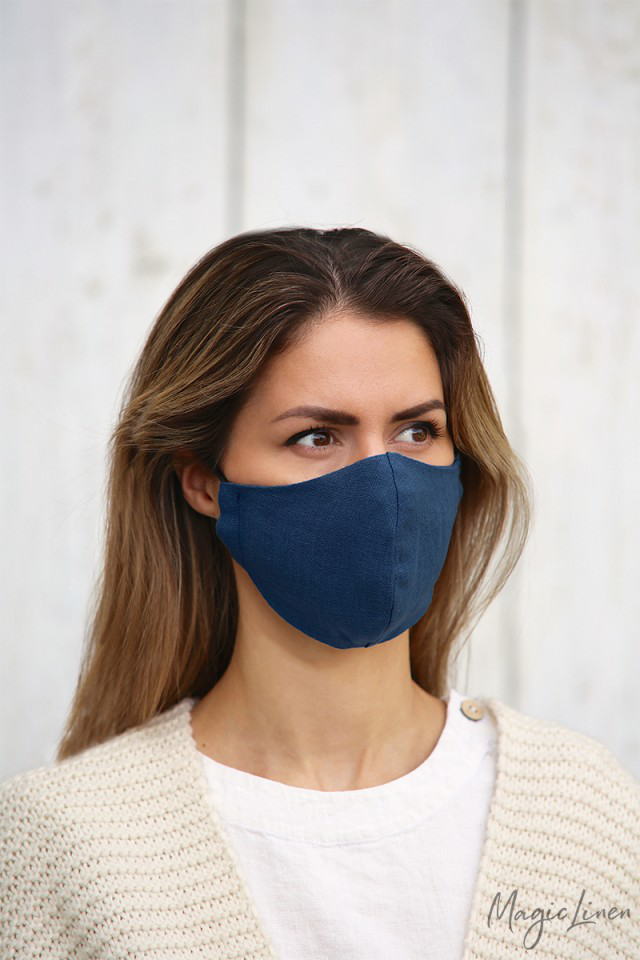

In [23]:
# get a sample image
sample_img_path = os.path.join('/content/datasets/', os.listdir('/content/datasets/')[213])
sample_img = PIL.Image.open(sample_img_path)
display(sample_img)

(-0.5, 299.5, 299.5, -0.5)

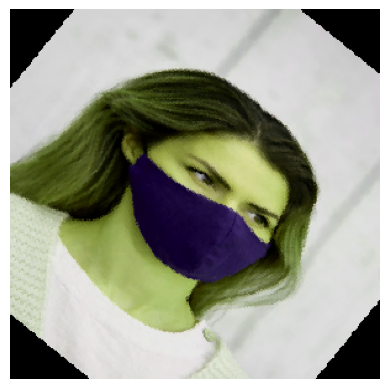

In [24]:
image = mask_data[213][0].cpu().numpy()
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)
plt.axis('off')

In [26]:
mask_data[213][0].size()

torch.Size([3, 300, 300])

### Split Dataset

In [19]:
split_size = (np.array([0.6, 0.2, 0.2]) * len(mask_data)).round().astype(np.int)

<ipython-input-19-30e4a902f0eb>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split_size = (np.array([0.6, 0.2, 0.2]) * len(mask_data)).round().astype(np.int)


In [25]:
train_data, eval_data, test_data = random_split(mask_data, split_size)

### Model Implementation

In [27]:
class MaskNoMaskClassifier(nn.Module):
  def __init__(self):
    super(MaskNoMaskClassifier, self).__init__()

    self.sequential = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # (32, 298, 298)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (32, 149, 149),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # (64, 147, 147)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (64, 73, 73)
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (128, 71, 71)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (128, 35, 35)
        nn.Flatten(), # 156800
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=156800, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=1)
    )

  def forward(self, features):
    features = self.sequential(features)
    features = self.classifier(features)

    return features

In [28]:
model = MaskNoMaskClassifier()

In [33]:
summary(model, (15, 3, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
MaskNoMaskClassifier                     [15, 1]                   --
├─Sequential: 1-1                        [15, 156800]              --
│    └─Conv2d: 2-1                       [15, 32, 298, 298]        896
│    └─ReLU: 2-2                         [15, 32, 298, 298]        --
│    └─MaxPool2d: 2-3                    [15, 32, 149, 149]        --
│    └─Conv2d: 2-4                       [15, 64, 147, 147]        18,496
│    └─ReLU: 2-5                         [15, 64, 147, 147]        --
│    └─MaxPool2d: 2-6                    [15, 64, 73, 73]          --
│    └─Conv2d: 2-7                       [15, 128, 71, 71]         73,856
│    └─ReLU: 2-8                         [15, 128, 71, 71]         --
│    └─MaxPool2d: 2-9                    [15, 128, 35, 35]         --
│    └─Flatten: 2-10                     [15, 156800]              --
├─Sequential: 1-2                        [15, 1]                   --
│    └